In [1]:
import os
import json
import re
import numpy as np


def normalize(s):
    return re.sub(" +", " ", re.sub("[^ \w]|\d", " ", s.lower()))


def select_ingrids(ingrids):
    words = []
    for s in ingrids:
        words += list(filter(lambda x: x, normalize(s).split(' ')))
    return words


def read_recipe(filename):
    with open(filename, 'r') as file:
        rec = json.loads(file.read())
        if "ingredients" not in rec:
            raise ValueError
        rec["ingredients"] = select_ingrids(rec["ingredients"])
        return rec


def read_all_recipes_ingrid(dir):
    all_rec = []
    k = 0
    for file in os.listdir(dir):
        if k % 1000 == 0:
            print("\r{}".format(k))
        try:
            all_rec.append(read_recipe(dir + "/" + file)["ingredients"])
        except ValueError:
            pass
        k += 1
    return all_rec


def read_all_recipes(dir):
    all_rec = []
    k = 0
    for file in os.listdir(dir):
        if k % 1000 == 0:
            print("\r{}".format(k))
        try:
            all_rec.append(read_recipe(dir + "/" + file))
        except ValueError:
            pass
        k += 1
    return all_rec


def code_ingrids(recipes):
    ingrids = {}
    for recipe in recipes:
        for ingrid in recipe["ingredients"]:
            if ingrid not in ingrids:
                ingrids[ingrid] = len(ingrids)
    return ingrids


def bag_of_words(recipe, ingrid_int_map):
    vec = np.zeros(len(ingrid_int_map))
    for ingrid in recipe["ingredients"]:
        if ingrid_int_map[ingrid] > len(ingrid_int_map):
            print(ingrid)
            print(ingrid_int_map[ingrid])
        vec[ingrid_int_map[ingrid]] += 1
    return vec


def recipe_vec(recipe, ingrid_int_map):
    vec = bag_of_words(recipe, ingrid_int_map)
    return vec


def recipes_vec(recipes):
    ingrid_int_map = code_ingrids(recipes)
    print("dict len:", len(ingrid_int_map))
    vec = np.zeros((len(recipes), len(ingrid_int_map)))
    for i in range(len(recipes)):
        vec[i] = recipe_vec(recipes[i], ingrid_int_map)
    return vec


In [2]:
all_recipes_ingrid_ = read_all_recipes_ingrid("../filtered_dataset")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


In [3]:
words_hist = dict()
more_then_two = dict()
for ingr_list in all_recipes_ingrid_:
    ingr_dict = {}
    for ingr in ingr_list:
        if ingr not in ingr_dict:
            ingr_dict[ingr] = 1
        else:
            ingr_dict[ingr] += 1
    for ingr, count in ingr_dict.items():
        if ingr not in words_hist:
            words_hist[ingr] = count
        else:
            words_hist[ingr] += count
        if count < 3:
            continue
        if ingr not in more_then_two:
            more_then_two[ingr] = count
        else:
            more_then_two[ingr] += count


In [4]:
more_then_two_list = sorted(more_then_two.items(), key=lambda kv: kv[1])
words_hist_list = sorted(words_hist.items(), key=lambda kv: kv[1])

In [5]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

In [7]:
print(len(words_hist_list), len(more_then_two_list))

1536 0


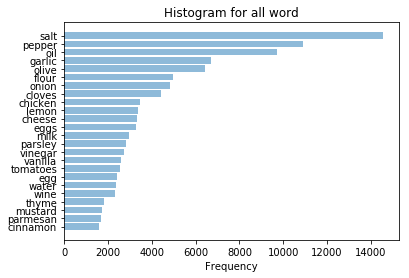

In [8]:
objects = []
performance = []

for element in words_hist_list:
    if element[1] > 1500:
        objects.append(element[0])
        performance.append(element[1])

y_pos = np.arange(len(objects))

 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Frequency')
plt.title('Histogram for all word')

plt.show()

In [10]:
all_recipes = read_all_recipes("../filtered_dataset")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


In [11]:
ingrid_names = list(words_hist.keys())

In [12]:
cuisines = [recipe["cuisine"].split(",")[0] for recipe in all_recipes]
cuisines_spect = {cuisine:0 for cuisine in (set(cuisines) - {""})}
recipes_with_cuisines = []
for recipe in all_recipes:
    cuisine = recipe["cuisine"].split(",")[0]
    if cuisine:
        recipes_with_cuisines.append(recipe)
        cuisines_spect[cuisine] += 1

In [13]:
len(recipes_with_cuisines)

6496

In [14]:
cuisines = {cuisine: {ingr:0 for ingr in ingrid_names} for cuisine, val in cuisines_spect.items()}

In [15]:
for recipe in recipes_with_cuisines:
    cuisine = recipe["cuisine"].split(",")[0]
    for ingr in recipe['ingredients']:
        cuisines[cuisine][ingr] += 1

In [16]:
cuisines = {cuisine:np.array([cuisines[cuisine][ingr] for ingr in ingrid_names]) for cuisine in cuisines.keys()}

In [17]:
cuisines = {cuisine:vec/np.linalg.norm(vec) for cuisine, vec in cuisines.items()}

In [22]:
cuisines_names = sorted(list(cuisines.keys()))
cuisines_names

['african',
 'american',
 'argentinean',
 'asian',
 'brazilian',
 'canadian',
 'caribbean',
 'central-american',
 'cuban',
 'european',
 'french',
 'indian',
 'israeli',
 'italian',
 'jewish-cooking',
 'latin-american',
 'lebanese',
 'mexican',
 'middle-eastern',
 'peruvian',
 'russian',
 'turkish',
 'venezuelan']

In [23]:
from scipy.spatial import distance

In [24]:
cuisines_distances = []
for cuisine_1 in cuisines_names:
    cuisines_distances.append([])
    for cuisine_2 in cuisines_names:
        cuisines_distances[-1].append(distance.euclidean(cuisines[cuisine_1], cuisines[cuisine_2]))


In [25]:
from skbio import DistanceMatrix
from skbio.tree import nj

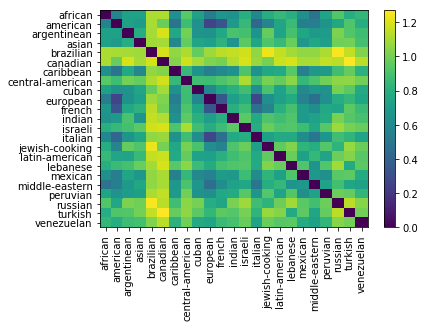

In [26]:
cuisines_distance_matrix = DistanceMatrix(cuisines_distances, cuisines_names)
cuisines_distance_matrix

In [27]:
tree = nj(cuisines_distance_matrix)
print(tree.ascii_art())

                    /-israeli
                   |
          /--------|                    /-turkish
         |         |          /--------|
         |         |         |          \-lebanese
         |          \--------|
         |                   |          /-middle-eastern
         |                    \--------|
         |                              \-african
         |
         |                              /-mexican
         |                    /--------|
         |                   |         |          /-caribbean
         |                   |          \--------|
         |                   |                   |          /-indian
         |          /--------|                    \--------|
         |         |         |                              \-asian
         |         |         |
         |         |         |          /-cuban
         |         |          \--------|
---------|         |                   |          /-peruvian
         |---------|              

In [28]:
newick_str = nj(cuisines_distance_matrix, result_constructor=str)
print(newick_str)

((israeli:0.476542, ((turkish:0.410386, lebanese:0.364030):0.090980, (middle-eastern:0.231859, african:0.251980):0.030016):0.022305):0.035656, (((mexican:0.277346, (caribbean:0.261671, (indian:0.337747, asian:0.319898):0.023832):0.031071):0.024165, (cuban:0.301268, (peruvian:0.330744, (latin-american:0.384491, argentinean:0.352493):0.016176):0.014425):0.022687):0.025317, (venezuelan:0.437602, (central-american:0.499427, (canadian:0.597423, brazilian:0.591234):0.054713):0.027641):0.017764):0.012635, ((russian:0.457184, jewish-cooking:0.365034):0.061460, ((italian:0.159639, european:0.111568):0.031032, (french:0.203067, american:0.134703):0.037249):0.052626):0.055333);


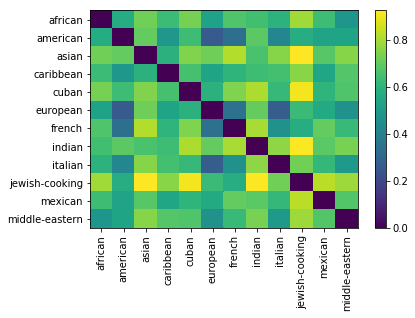

In [73]:
well_presented_cuisines = {cuisine: {ingr:0 for ingr in ingrid_names} for cuisine, val in cuisines_spect.items() if val > 37}

for recipe in recipes_with_cuisines:
    cuisine = recipe["cuisine"].split(",")[0]
    if cuisine not in well_presented_cuisines:
        continue
    for ingr in recipe['ingredients']:
        well_presented_cuisines[cuisine][ingr] += 1

well_presented_cuisines = {cuisine:np.array([well_presented_cuisines[cuisine][ingr] for ingr in ingrid_names]) for cuisine in well_presented_cuisines.keys()}

well_presented_cuisines = {cuisine: vec/np.linalg.norm(vec) for cuisine, vec in well_presented_cuisines.items()}

well_presented_cuisines_names = sorted(list(well_presented_cuisines.keys()))
well_presented_cuisines_distances = []
for cuisine_1 in well_presented_cuisines_names:
    well_presented_cuisines_distances.append([])
    for cuisine_2 in well_presented_cuisines_names:
        well_presented_cuisines_distances[-1].append(distance.euclidean(well_presented_cuisines[cuisine_1], well_presented_cuisines[cuisine_2]))
well_presented_cuisines_distance_matrix = DistanceMatrix(well_presented_cuisines_distances, well_presented_cuisines_names)
well_presented_cuisines_distance_matrix

In [74]:
well_presented_tree = nj(well_presented_cuisines_distance_matrix)
print(well_presented_tree.ascii_art())

                    /-caribbean
          /--------|
         |         |          /-indian
         |          \--------|
         |                    \-asian
         |
         |          /-mexican
         |---------|
         |          \-cuban
---------|
         |                              /-italian
         |                    /--------|
         |                   |          \-european
         |          /--------|
         |         |         |          /-american
         |         |          \--------|
         |         |                   |          /-jewish-cooking
          \--------|                    \--------|
                   |                              \-french
                   |
                   |          /-middle-eastern
                    \--------|
                              \-african


In [75]:
well_presented_newick_str = nj(well_presented_cuisines_distance_matrix, result_constructor=str)
print(well_presented_newick_str)

((caribbean:0.243876, (indian:0.327914, asian:0.329731):0.041628):0.034689, (mexican:0.263767, cuban:0.337015):0.022805, (((italian:0.173043, european:0.098164):0.047237, (american:0.135760, (jewish-cooking:0.378682, french:0.197913):0.032648):0.029887):0.057957, (middle-eastern:0.244717, african:0.239122):0.057952):0.047724);
